# Problem 1

In [115]:
import dolfin

import torch
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [116]:
class RecurrentBlock(torch.nn.Module):
    def __init__(self, in_size, hidden_size):
        super(RecurrentBlock, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(in_features=in_size, out_features=hidden_size)
        self.activation1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.activation2 = torch.nn.Tanh()
    
    def forward(self, x):
        if self.in_size < self.hidden_size:
            padding = (0, self.hidden_size - self.in_size)
            retain_x = torch.nn.functional.pad(x, padding, mode='constant', value=0)
        else:
            retain_x = x
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = x + retain_x
        return x

class RitzModel(torch.nn.Module):
    def __init__(self, input_dim=2, num_blocks=4, hidden_size=10):
        super(RitzModel, self).__init__()

        self.blocks = torch.nn.ModuleList([
            RecurrentBlock(in_size=input_dim if block_i == 0 else hidden_size, hidden_size=hidden_size)
            for block_i in range(num_blocks)])
        self.fc_out = torch.nn.Linear(hidden_size, 1)

        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=0.1)

        self.nb_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x):
                
        for block in self.blocks:
            x = block(x)
        u_theta = self.fc_out(x)

        return u_theta

In [117]:
class FullyConnectedNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, activation_function=0):
        super(FullyConnectedNetwork, self).__init__()

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, 1)

        self.activation_function = [torch.nn.ReLU(), torch.nn.Tanh(), torch.nn.Sigmoid()][activation_function]

    def forward(self, x):
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        u_x = self.fc4(x)
        return u_x

In [118]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x_omega, ux_omega, fx, ux_boundary, cl_boundary, reg_boundary=500):
        grad_u = torch.autograd.grad(inputs=x_omega, outputs=ux_omega, grad_outputs=torch.ones_like(ux_omega), create_graph=True)[0]
        grad_ux1, grad_ux2 = grad_u[:, 0], grad_u[:, 1]
        
        physical_term1 = grad_ux1.pow(2) + grad_ux2.pow(2)
        physical_term2 = fx*ux_omega
        boundary_term = (cl_boundary - ux_boundary).pow(2)

        loss_term1 = 4/2*physical_term1.mean()
        loss_term2 = 4*physical_term2.mean()
        loss_term3 = boundary_term.mean()
        loss = loss_term1 - loss_term2 + reg_boundary*loss_term3

        return loss, loss_term1, loss_term2, loss_term3
    
class Omega2D(Dataset):
    def __init__(self, n_omega=100, n_boundary=75, x_bounds=[-1, 1], y_bounds=[-1, 1]):

        self.n_omega = n_omega
        self.n_boundary = n_boundary
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

        self.omega_train, self.boundary_train = self._create_points_for_training()
        self.mesh_eval = self._create_points_for_evaluation()

    def _create_points_for_training(self):
        xmin, xmax = self.x_bounds
        ymin, ymax = self.y_bounds

        x = np.random.uniform(xmin, xmax, self.n_omega)
        y = np.random.uniform(ymin, ymax, self.n_omega)
        omega_coordinates = np.column_stack((x, y))

        n_per_boundary = self.n_boundary//4
        x_left, y_left = xmin*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_right, y_right = xmax*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, n_per_boundary), ymin*np.ones(n_per_boundary)
        x_top, y_top = np.random.uniform(xmin, xmax, n_per_boundary), ymax*np.ones(n_per_boundary)
        x_boundary = np.concatenate((x_left, x_right, x_bottom, x_top))
        y_boundary = np.concatenate((y_left, y_right, y_bottom, y_top))
        boundary_coordinates = np.column_stack((x_boundary, y_boundary))

        return omega_coordinates, boundary_coordinates
    
    def _create_points_for_evaluation(self):
        mesh = dolfin.RectangleMesh(dolfin.Point(self.x_bounds[0], self.y_bounds[0]), dolfin.Point(self.x_bounds[1], self.y_bounds[1]), 100, 100)
        mesh_coordinates = mesh.coordinates()

        return np.array(mesh_coordinates)

    def plot(self):
        plt.scatter(self.omega_train[:, 0], self.omega_train[:, 1], c='blue', alpha=0.6, label='Omega points')
        plt.scatter(self.boundary_train[:, 0], self.boundary_train[:, 1], c='red', alpha=0.6, label='Boundary points')
        plt.title('Domain with corner singularity along the x-axis at y=0')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

In [126]:
class ExampleOne():
    def __init__(self, hidden_size, actv_func=1):
        
        self.model = FullyConnectedNetwork(2, hidden_size, actv_func)
        # self.model = RitzModel(input_dim=2, num_blocks=4, hidden_size=hidden_size)
        self.criterion = DeepRitzLoss()

        self.total_loss = []
        self.physical_loss1 = []
        self.physical_loss2 = []
        self.boundary_loss = []

    def train(self, n_iter):

        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.model.train()

        for iter_i in range(n_iter):
            integration_grid = Omega2D(10000, 2500)

            x_omega = torch.FloatTensor(integration_grid.omega_train)
            x_boundary = torch.FloatTensor(integration_grid.boundary_train)
            fx_omega = torch.FloatTensor(self.f(x_omega)).unsqueeze(1)
            cl_boundary = self.cl_boundary(x_boundary)

            x_omega.requires_grad = True

            model_optimizer.zero_grad()
            ux_omega = self.model(x_omega)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')

    def cl_boundary(self, x):
        return torch.zeros(x.shape[0], 1)
    
    def f(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        fx = 2*(1-x2**2) + 2*(1-x1**2)
        return fx
    
    def u(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        u = (1-x1**2)*(1-x2**2)
        return u

def asses_solution(example):
    model = example.model
    model.eval()

    evaluation_grid = Omega2D()
    x_eval = torch.FloatTensor(evaluation_grid.mesh_eval)

    u_pred = (model(x_eval).detach().numpy()).reshape(101, 101)
    u_exact = (example.u(x_eval).numpy()).reshape(101, 101)

    print(np.mean(np.abs(u_exact-u_pred)))
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axes[0].imshow(u_pred, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
    axes[0].set_title('Predicted solution')
    fig.colorbar(im0, ax=axes[0], shrink=0.6)

    im1 = axes[1].imshow(u_exact, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
    axes[1].set_title('Exact solution')
    fig.colorbar(im1, ax=axes[1], shrink=0.6)

    plt.show()

In [120]:
torch.manual_seed(15)

In [127]:
model1 = ExampleOne(hidden_size=20, actv_func=1)
model1.train(5000)

Iteration 0, loss: 11.084613800048828
Iteration 100, loss: -0.11559756845235825
Iteration 200, loss: -0.16954752802848816
Iteration 300, loss: -0.2373979389667511
Iteration 400, loss: -0.3967199921607971
Iteration 500, loss: -0.8430488109588623
Iteration 600, loss: -2.424464464187622
Iteration 700, loss: -2.746309995651245
Iteration 800, loss: -2.744277238845825
Iteration 900, loss: -2.809892177581787
Iteration 1000, loss: -2.745002031326294
Iteration 1100, loss: -2.8302745819091797
Iteration 1200, loss: -2.807720422744751
Iteration 1300, loss: -2.7769155502319336
Iteration 1400, loss: -2.8496475219726562
Iteration 1500, loss: -2.7641894817352295
Iteration 1600, loss: -2.8598008155822754
Iteration 1700, loss: -2.816493511199951
Iteration 1800, loss: -2.7518136501312256
Iteration 1900, loss: -2.917731285095215
Iteration 2000, loss: -2.8116719722747803
Iteration 2100, loss: -2.744431734085083
Iteration 2200, loss: -2.8861777782440186
Iteration 2300, loss: -2.7981150150299072
Iteration 24

5.688888888888889


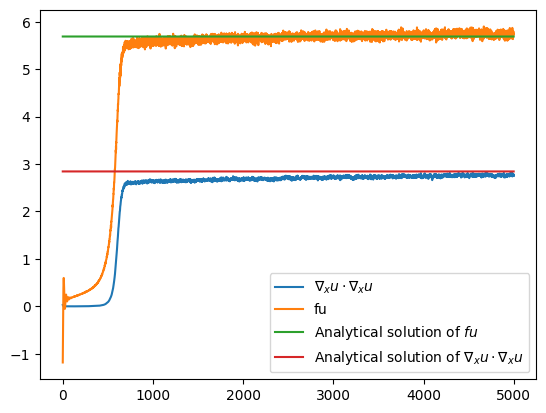

In [128]:
plt.plot(model1.physical_loss1, label=r'$\nabla_x u \cdot \nabla_x u$')
plt.plot(model1.physical_loss2, label=r'fu')
plt.plot(np.ones(len(model1.physical_loss2))*256/45, label=r'Analytical solution of $fu$')
plt.plot(np.ones(len(model1.physical_loss1))*128/45, label=r'Analytical solution of $\nabla_x u \cdot \nabla_x u$')
plt.legend()
print(256/45)

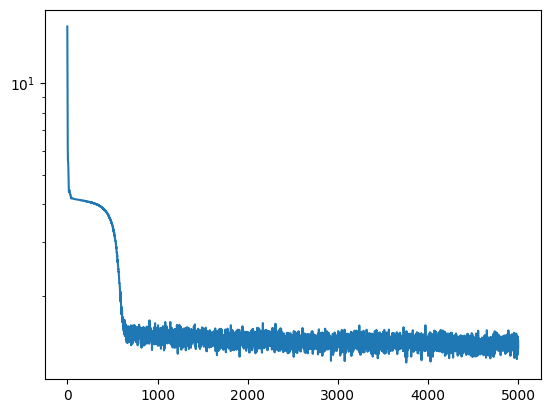

In [129]:
total_loss = model1.total_loss
plt.plot(np.array(total_loss) - 64/45 + 256/45, label='Total loss')
plt.yscale('log')
plt.show()

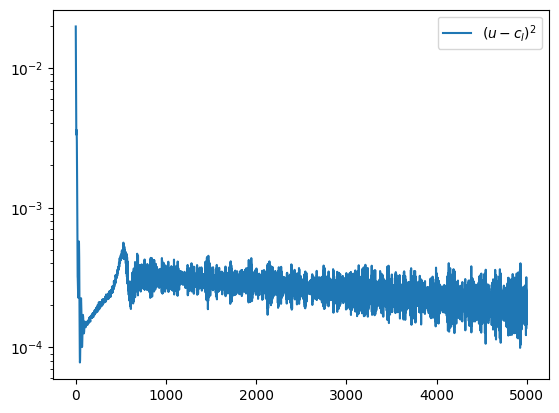

In [130]:
plt.plot(model1.boundary_loss, label=r'$(u - c_l)^2$')
plt.yscale('log')
plt.legend()

0.0088154515


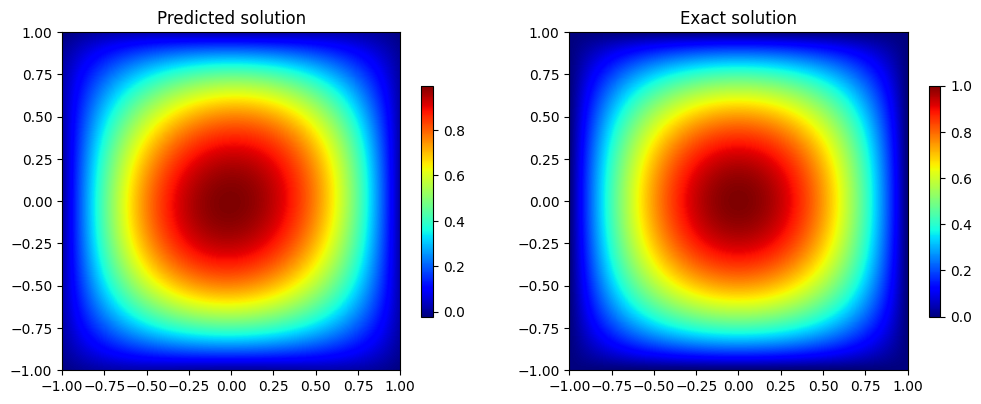

In [131]:
asses_solution(model1)